In [1]:
import glob
from string import digits

import pandas as pd
import numpy as np
import xarray as xr
#import pycountry
import rasterio
import geopandas as gpd
import rasterio.mask
from rasterstats import zonal_stats

import matplotlib.pyplot as plt
import shapely 

hh_end_use = "https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?file=data/nrg_d_hhq.tsv.gz" 
energy_balance = '/cluster/work/cpesm/brynmorp/euro-spores/data/annual_energy_balance.nc'
countries = [
    "Austria", "Belgium", "Bulgaria", "Croatia", "Czech Republic", "Cyprus", "Denmark", "Estonia", 
    "Finland", "France", "Germany", "Greece", "Hungary", "Ireland", "Italy", "Latvia", 
    "Lithuania", "Luxembourg", "Netherlands", "Poland", "Portugal", "Romania", "Slovakia",
    "Slovenia", "Spain", "Sweden", "United Kingdom", "Albania", "Bosnia and Herzegovina", 
    "North Macedonia", "Montenegro", "Norway", "Serbia", "Switzerland", "Iceland"
]
ch_end_use = "https://www.bfe.admin.ch/bfe/en/home/versorgung/statistik-und-geodaten/energiestatistiken/energieverbrauch-nach-verwendungszweck.exturl.html/aHR0cHM6Ly9wdWJkYi5iZmUuYWRtaW4uY2gvZGUvcHVibGljYX/Rpb24vZG93bmxvYWQvOTg1NA==.html"
ch_energy_use = "https://www.bfe.admin.ch/bfe/en/home/versorgung/statistik-und-geodaten/energiestatistiken/gesamtenergiestatistik.exturl.html/aHR0cHM6Ly9wdWJkYi5iZmUuYWRtaW4uY2gvZGUvcHVibGljYX/Rpb24vZG93bmxvYWQvNzUxOQ==.html"

idx = pd.IndexSlice

%matplotlib inline

In [12]:
def tj_to_ktoe(array):
    array *= 23.8845896627e-3
    return array


def ktoe_to_gwh(array):
    array *= 11.63
    return array

def tj_to_twh(array):
    array /= 3600
    return array

def get_alpha2(i, eurostat=True):
    if i == "United Kingdom" and eurostat is True:
        return 'UK'
    elif i == "Greece" and eurostat is True:
        return 'EL'
    return pycountry.countries.lookup(i).alpha_2


def get_eu_sheet(path_to_excel, sheet):
    _df = (
        pd.read_excel(
        path_to_excel, sheet_name=sheet, skiprows=3, skipfooter=5, index_col=1)
        .drop('Unnamed: 0', axis=1)
        .where(lambda x: x != ':')
        .drop(['EU-28', 'Kosovo*'])
    )
    _df.index = _df.index.str.strip()
    _df.loc['Cyprus'] = _df.loc['Greece']
    _df.loc['Estonia'] = _df.loc['Latvia']

    # No data for Norway for cooking
    if _df.loc['Norway'].isnull().sum() > 0:
        _df.loc['Norway'] = _df.loc['Sweden']
    _df.index = _df.index.map(get_alpha2)
    return _df


def get_ch_sheet(path_to_excel, sheet, skipfooter):
    _df = (
        pd.read_excel(
        path_to_excel, sheet_name=sheet, skiprows=9, skipfooter=skipfooter, index_col=1)
        .drop('Unnamed: 0', axis=1)
    )
    _df.index = _df.index.str.strip()
    _df = _df.astype(float) * 1000 # PJ -> TJ
    return _df

    
def get_absolute_vals(end_use_df, energy_use):
    return (end_use_df / 100).mul(energy_use.reindex(end_use_df.index), axis=0)

def to_numeric(series):
    return pd.to_numeric(series, errors='coerce')

ch_hh_end_use_translation = {
    'Raumwärme': 'space_heating',
    'Warmwasser': 'water_heating',
    #'Klima, Lüftung, HT': 'Space cooling',
    #'Unterhaltung, I&K': 'Lighting and appliances',
    'Kochen / Geschirrspülen': 'cooking',
    #'Beleuchtung': 'Lighting and appliances',
    #'Waschen & Trocknen': 'Lighting and appliances',
    #'Gefrieren & Kühlen': 'Lighting and appliances',
    #'sonstige Elektrogeräte': 'Lighting and appliances',
}

ch_energy_carrier_translation = {
     'Heizöl': 'oil',
     'Erdgas': 'natural_gas',
     'El. Widerstandsheizungen': 'direct_electric',
     'El. Wärmepumpen 1)': 'heat_pump',
     "El. Ohm'sche Anlagen": 'direct_electric',
     'El. Wärmepumpen': 'heat_pump',	
     'Elektrizität': 'electricity',
     'Holz': 'biomass',
     'Kohle': 'coal',
     'Fernwärme': 'heat',
     'Umweltwärme': 'ambient_heat',
     'Solar': 'solar_thermal',
}

hh_end_use_carrier_codes = {
    'C0000X0350-0370': 'coal',
    'E7000': 'electricity', 
    'G3000': 'natural_gas', 
    'H8000': 'heat', 
    'O4000XBIO': 'oil',
    'R5110-5150_W6000RI': 'biomass', 
    'R5300': 'biogas',  
    'RA410': 'solar_thermal', 
    'RA600': 'ambient_heat',
    'P1000': 'coal', 
    'S2000': 'coal',
    'TOTAL': 'total'
}
hh_end_use_carrier_names = {
    'SFF_P1000_S2000': 'Solid fossil fuels and peat',
    'G3200': 'LNG', 
    'O4000': 'Oil and petroleum',
    'O4671': 'Gas oil and diesel oil'
}
END_USE_CAT_NAMES = {
    'FC_OTH_HH_E_CK': 'cooking', 
    'FC_OTH_HH_E_SH': 'space_heating', 
    'FC_OTH_HH_E_WH': 'water_heating'   
}
HH_END_USE_CARRIERS_ALL = {  # we keep these carriers, since we don't want fossils subcategories but we do want renewables subcategories
    'E7000': 'electricity', 
    'G3000': 'natural_gas', 
    'H8000': 'heat', 
    'O4000': 'oil', 
    'R5110-5150_W6000RI': 'biomass', 
    'R5300': 'biogas', 
    'RA410': 'solar_thermal', 
    'RA600': 'ambient_heat', 
    'SFF_P1000_S2000': 'coal', 
    'TOTAL': 'total'
}
hh_end_use_renewables = [
    'R5110-5150_W6000RI', 'R5300', 'RA410', 'RA600'
]

In [3]:
# Get population per merra-2 site id and country

units = '/cluster/work/cpesm/brynmorp/euro-spores/land-eligibility/build/national/units.geojson'
air_temp = '/cluster/work/cpesm/brynmorp/euro-spores/land-eligibility/data/capacityfactors/temperature.nc'
population = '/cluster/work/cpesm/brynmorp/euro-spores/land-eligibility/build/population-europe.tif'
temperature_threshold = 15.5
out_path = 'test.csv'

EPSG_3035_PROJ4 = "+proj=laea +lat_0=52 +lon_0=10 +x_0=4321000 +y_0=3210000 +ellps=GRS80 +units=m +no_defs "
WGS84 = "EPSG:4326"

def get_hdd(air_temp, temperature_threshold):
    hdh = air_temp - temperature_threshold  # hdh = heating degree hour
    hdd = hdh.where(hdh >= 0, other=0) / 24  # div by 24 for heating degree hour -> heating degree day

    annual_hdd = hdd.groupby('time.year').sum('time').to_pandas()

    return annual_hdd

# Get population per merra-2 site id and country
europe_shape = gpd.read_file(units)
if isinstance(europe_shape.crs, dict):
    europe_shape.crs = europe_shape.crs['init']  # {'init': '...'} is deprecated

air_temp_ds = xr.open_dataset(air_temp)
coords = air_temp_ds[['lat', 'lon']].to_dataframe()
temperatures = air_temp_ds['temperature']
annual_hdd = get_hdd(temperatures, temperature_threshold)

points = gpd.GeoDataFrame(
    geometry=gpd.points_from_xy(coords.lon.values, coords.lat.values),
    index=coords.index, crs=WGS84
)
points_m = points.to_crs(EPSG_3035_PROJ4)
polys_m = gpd.GeoDataFrame(
    index=points_m.index, geometry=points_m.buffer(25000).envelope  # 50km horizontal resolution
)
polys_eu = gpd.overlay(polys_m.to_crs(WGS84).reset_index(), europe_shape.to_crs(WGS84))

with rasterio.open(population) as src:
    array = src.read(1)
    crs = src.crs
    affine = src.transform

    pop_polys = zonal_stats(polys_eu.to_crs(crs), array, affine=affine, stats='sum', nodata=0)
    polys_eu['population'] = [i['sum'] for i in pop_polys]

    pop_eu = zonal_stats(europe_shape.to_crs(crs), array, affine=affine, stats='sum', nodata=0)
    europe_shape['population'] = [i['sum'] for i in pop_eu]

sig_fig = lambda i: f'{float(f"{i:.4g}"):g}'
assert (
    sig_fig(polys_eu['population'].sum()) ==
    sig_fig(europe_shape['population'].sum())
)
pop_polys_with_hdd = pd.concat(
    [polys_eu.set_index('site')[['country_code', 'population']], annual_hdd],
    axis=1
)
pop_polys_with_hdd.to_csv(out_path)

AssertionError: 

In [4]:
polys_eu['population'].sum()

529805968.9305297

In [5]:
europe_shape['population'].sum()

530283049.21537054

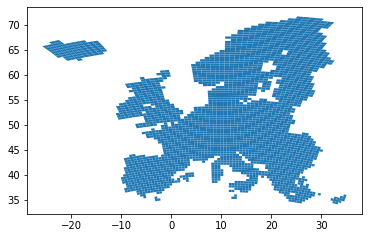

In [7]:
polys_m.to_crs(WGS84).plot()

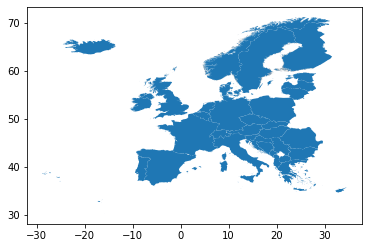

In [8]:
europe_shape.to_crs(WGS84).plot()

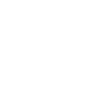

In [28]:
shapely.geometry.Polygon(shapely.geometry.box(0, 10, 0, 10), holes=[shapely.geometry.box(0, 0.5, 0, 0.5)])

In [10]:
sites = polys_eu.loc[polys_eu.country_code == 'CHE'].site.values
air_temp.temperature.loc[{'site': sites}].to_pandas()

time,2000-01-01 00:00:00,2000-01-01 01:00:00,2000-01-01 02:00:00,2000-01-01 03:00:00,2000-01-01 04:00:00,2000-01-01 05:00:00,2000-01-01 06:00:00,2000-01-01 07:00:00,2000-01-01 08:00:00,2000-01-01 09:00:00,...,2018-12-31 14:00:00,2018-12-31 15:00:00,2018-12-31 16:00:00,2018-12-31 17:00:00,2018-12-31 18:00:00,2018-12-31 19:00:00,2018-12-31 20:00:00,2018-12-31 21:00:00,2018-12-31 22:00:00,2018-12-31 23:00:00
site,,,,,,,,,,,,,,,,,,,,,
872,-2.255646,-2.054840,-1.839325,-1.676300,-1.608398,-1.563049,-1.654297,-1.700195,-1.227783,-0.172089,...,3.803345,1.533447,0.606293,0.501526,0.393707,0.251404,0.102844,-0.069824,-0.207336,-0.272766
873,-2.256714,-1.999817,-1.722626,-1.457275,-1.140411,-0.880371,-0.878296,-0.859589,-0.440735,0.210602,...,3.284180,1.610474,0.936584,0.771515,0.565002,0.297089,0.035431,-0.078247,-0.044678,0.200317
903,-10.691071,-10.845398,-10.905090,-10.847870,-11.002136,-11.079865,-11.212036,-11.388519,-10.903290,-8.977539,...,0.380432,-0.229828,-1.395264,-2.401794,-3.178406,-3.817657,-4.226379,-4.477051,-4.730225,-4.588531
904,-6.458008,-6.397003,-6.302124,-6.173157,-6.192657,-6.202179,-6.287933,-6.295654,-5.699677,-3.877960,...,2.069519,0.998962,0.232544,-0.369507,-0.962494,-1.485596,-2.011749,-2.407501,-2.619080,-2.513031
905,-4.044312,-3.898499,-3.808838,-3.711761,-3.558716,-3.513153,-3.582336,-3.477264,-2.721588,-1.119141,...,2.669312,1.514221,1.014374,0.713989,0.386688,0.081573,-0.251190,-0.455414,-0.453888,-0.318634
906,-2.779663,-2.631653,-2.557922,-2.408966,-2.100525,-1.936707,-1.917603,-1.820099,-1.231934,-0.342072,...,2.660919,2.036682,1.714050,1.484558,1.232941,0.946930,0.741333,0.647308,0.629150,0.728943
907,-1.544189,-1.369507,-1.286346,-1.153870,-0.900940,-0.645813,-0.481659,-0.371063,0.024231,0.417450,...,2.598419,2.208344,1.998108,1.861389,1.723907,1.493958,1.338226,1.296539,1.140717,1.081940
936,-12.266632,-12.523590,-12.688812,-13.014069,-13.470886,-13.824371,-14.124847,-14.281555,-13.371887,-11.090332,...,-0.153046,-2.228363,-4.086060,-4.867645,-5.437958,-5.608582,-5.091522,-4.090820,-3.836151,-3.606384
937,-9.323334,-9.333527,-9.385834,-9.426300,-9.578522,-9.751007,-10.186646,-10.418854,-9.843201,-7.973480,...,0.036346,-1.207520,-2.485291,-3.021606,-3.430145,-3.777954,-4.238312,-4.475372,-4.584686,-4.257141


In [13]:
i = europe_shape['pop'].sum()
f'{float(f"{i:.4g}"):g}'

'5.303e+08'

In [21]:
pd.concat((europe_shape.set_index('id')['pop'].sort_index(), polys_eu.groupby('id').sum()['pop'].sort_index()), axis=1)

,pop,pop
id,,
ALB,2.877957e+06,2.877957e+06
AUT,8.545747e+06,8.545747e+06
BEL,1.129256e+07,1.129256e+07
BGR,7.113306e+06,7.113306e+06
BIH,3.816038e+06,3.816038e+06
CHE,8.255436e+06,8.255436e+06
CYP,1.155475e+06,1.155475e+06
CZE,1.055298e+07,1.055298e+07
DEU,8.070915e+07,8.070915e+07


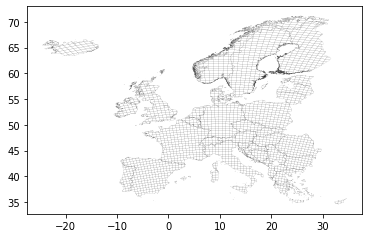

In [11]:
polys_eu.plot(fc='None', ec='black', lw=0.05)

id
ALB    2.877957e+06
AUT    8.545747e+06
BEL    1.129256e+07
BGR    7.113306e+06
BIH    3.816038e+06
CHE    8.255436e+06
CYP    1.155475e+06
CZE    1.055298e+07
DEU    8.070915e+07
DNK    5.582467e+06
ESP    4.358310e+07
EST    1.303236e+06
FIN    5.469811e+06
FRA    6.415787e+07
GBR    6.446631e+07
GRC    1.069509e+07
HRV    4.114857e+06
HUN    9.853504e+06
IRL    4.649515e+06
ISL    3.064289e+05
ITA    5.924383e+07
LTU    2.866622e+06
LUX    5.645764e+05
LVA    1.964770e+06
MKD    2.078502e+06
MNE    6.080721e+05
NLD    1.690214e+07
NOR    5.021789e+06
POL    3.857155e+07
PRT    9.836321e+06
ROU    1.951964e+07
SRB    6.971185e+06
SVK    5.423058e+06
SVN    2.086176e+06
SWE    9.646886e+06
Name: pop, dtype: float64

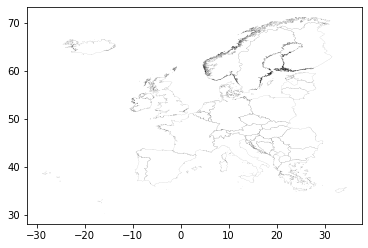

In [14]:
europe_shape.plot(fc='None', ec='black', lw=0.05)

In [4]:
hh_end_use_df = pd.read_csv(hh_end_use, delimiter='\t', index_col=0)
hh_end_use_df.index = (
    hh_end_use_df.index.str.split(',', expand=True)
    .rename(['cat_code', 'carrier_code', 'unit', 'country'])
)
hh_end_use_df.columns = hh_end_use_df.columns.astype(int)
hh_end_use_df = (
    hh_end_use_df
    .loc[idx[[i for i in END_USE_CAT_NAMES.keys()], [i for i in HH_END_USE_CARRIERS_ALL.keys()], 'TJ', [get_alpha2(i) for i in countries]], :]
    .transform(to_numeric)
    .astype(float)
    .dropna(how='all')
)
hh_end_use_df.index = (
    hh_end_use_df.index
    .remove_unused_levels()
    .set_levels([END_USE_CAT_NAMES.values(), HH_END_USE_CARRIERS_ALL.values()], level=['cat_code', 'carrier_code'])
    .rename(['cat_name', 'carrier_name'], level=['cat_code', 'carrier_code'])
)

In [9]:
energy_balance_ds = xr.open_dataset(energy_balance)
#
#hh_end_use_df = pd.read_csv(hh_end_use, delimiter='\t', index_col=0)
#hh_end_use_df.index = hh_end_use_df.index.str.split(',', expand=True).rename(['cat_code', 'carrier_code', 'unit', 'country'])
#hh_end_use_df.columns = hh_end_use_df.columns.astype(int)
#hh_end_use_df = hh_end_use_df.xs('TJ', level='unit')
#hh_end_use_df = hh_end_use_df.where(hh_end_use_df != ':').where(hh_end_use_df != ': ').astype(float).groupby(
#    [hh_end_use_cat_codes, 
#     {get_alpha2(i): get_alpha2(i) for i in countries}, 
#     {i: i for i in hh_end_use_df.index.get_level_values('carrier_code').unique()}], 
#    level=['cat_code', 'country', 'carrier_code']
#).sum()
#
#hh_energy_use = (
#    energy_balance_ds
#    .where(energy_balance_ds.sub_cat_2 == 'Households', drop=True)
#    .to_dataframe()
#    .groupby([hh_end_use_carrier_codes, {i: i for i in hh_end_use_df.columns}], level=['carrier_code', 'year'])
#    .sum()
#    .T
#    .rename(index={'EL': 'GR', 'UK': 'GB'})
#    .stack(0)
#)
#hh_energy_use_tot = (
#    energy_balance_ds
#    .where((energy_balance_ds.sub_cat_2 == 'Households'), drop=True)
#    .loc[{'carrier_code': 'TOTAL', 'year': 2017}]
#    .to_dataframe()
#    .T
#    .rename(index={'EL': 'GR', 'UK': 'GB'})
#    .loc[:, 'FC_OTH_HH_E']
#    .reindex(hh_energy_use.index)
#)

#hh_end_use_df = get_eu_sheet(hh_end_use, 'Table 3')
#hh_end_use_df_sh = get_eu_sheet(hh_end_use,'Table 4 Spaceheating')
#hh_end_use_df_hw = get_eu_sheet(hh_end_use,'Table 5 Waterheating')
#hh_end_use_df_c = get_eu_sheet(hh_end_use, 'Table 6 Cooking')

ch_hh_end_use_df_tot = get_ch_sheet(ch_end_use, 'Tabelle 15', skipfooter=5).groupby(ch_hh_end_use_translation).sum()
ch_hh_end_use_df_tot.index.rename('cat_name', inplace=True)
ch_hh_end_use_df_sh = get_ch_sheet(ch_end_use,'Tabelle 18', skipfooter=8).groupby(ch_energy_carrier_translation).sum()
ch_hh_end_use_df_hw = get_ch_sheet(ch_end_use,'Tabelle 20', skipfooter=5).groupby(ch_energy_carrier_translation).sum()
ch_hh_end_use_df_c = get_ch_sheet(ch_end_use, 'Tabelle21', skipfooter=4).groupby(ch_energy_carrier_translation).sum()

ch_hh_end_use_df = (
    pd.concat(
        [ch_hh_end_use_df_sh, ch_hh_end_use_df_hw, ch_hh_end_use_df_c], 
        keys=('space_heating', 'water_heating', 'cooking'), 
        names=['cat_name', 'carrier_name']
    )
    .append(ch_hh_end_use_df_tot.assign(carrier_name='total').set_index('carrier_name', append=True))
    .assign(unit='TJ', country='CH')
    .set_index(['unit', 'country'], append=True)
    .drop('Δ ’00 – ’18', axis=1)
)
ch_hh_end_use_df.columns = ch_hh_end_use_df.columns.astype(int)

In [10]:
hh_end_use_df = hh_end_use_df.append(ch_hh_end_use_df, sort=True).sort_index()
hh_end_use_df = hh_end_use_df.where(hh_end_use_df > 0).dropna(how='all')

In [14]:
hh_energy_use = (
    energy_balance_ds
    .where(energy_balance_ds.sub_cat_2 == 'Households', drop=True)
    .to_dataframe()
    .groupby([hh_end_use_carrier_codes, {i: i for i in range(2000, 2019)}], level=['carrier_code', 'year'])
    .sum()
    .T
    .rename(index={'EL': 'GR', 'UK': 'GB'})
    .stack(0)
)

In [15]:
hh_energy_use

year                      2010          2011          2012          2013  \
   carrier_code                                                            
SE ambient_heat       0.000000      0.000000      0.000000      0.000000   
   biogas            65.849814     12.611063     29.999045     35.038693   
   biomass          617.965988   1170.344893   1189.261488    968.782841   
   coal               0.000000      0.000000      0.000000      0.000000   
   electricity     3953.740327   3641.788478   3775.494411   3740.670679   
   heat            3233.710710   2504.561957   2734.045094   2643.856884   
   natural_gas       76.053310     69.475494     45.120378     33.404987   
   oil              310.049926    263.132027    259.031936    251.503602   
   solar_thermal     10.318143     11.010796     11.082450     11.177988   
   total           8282.351803   7684.931276   8056.624087   7696.895963   
DE ambient_heat     476.569218    547.625872    624.486481    702.851820   
   biogas           138.363428    166.069552    199.101939    227.572370   
   biomass         6646.651381   5931.809497   7067.880004   7326.144072   
   coal             992.141564    865.783009    742.844941    691.631461   
   electricity    12184.006879  11745.485813  11779.879622  11693.895099   
   heat            4511.416834   3925.360657   3376.134518   4406.372409   
   natural_gas    23906.706793  19757.975064  21618.766122  22509.200344   
   oil            14337.902073  12366.641588  13028.519490  14208.842720   
   solar_thermal    454.953664    521.233400    542.538454    548.414063   
   total          63838.844153  56020.306368  59188.186539  62517.366748   
PL ambient_heat      18.971780     23.091396     27.211013     29.827568   
   biogas             0.000000      0.000000      0.000000      0.000000   
   biomass         2692.891946   2746.727811   2790.914302   2790.914302   
   coal            7886.419987   6804.855498   7186.405608   6919.582736   
   electricity     2460.447120   2429.750645   2434.909716   2445.571797   
   heat            4657.494984   4179.803191   4299.226139   4203.687781   
   natural_gas     3545.120378   3235.662081   3377.214101   3419.969905   
   oil              701.884494    663.107863    639.321200    599.121047   
   solar_thermal      7.643069      9.267221     10.891373     20.445209   
   total          21982.973690  20103.954824  20779.220424  20443.637399   
...                        ...           ...           ...           ...   
AL ambient_heat       0.000000      0.000000      0.000000      0.000000   
   biogas             0.000000      0.000000      0.000000      0.000000   
   biomass          179.994268    170.010509    160.002866    160.002866   
   coal               0.000000      0.000000      0.235096      0.235096   
   electricity      222.527945    233.190026    262.252794    331.900258   
   heat               0.000000      0.000000      0.000000      0.000000   
   natural_gas        0.000000      0.000000      0.000000      0.000000   
   oil               84.510294     89.705025     81.221219     82.490279   
   solar_thermal      2.006306      5.374033      5.374033      5.374033   
   total            489.038812    498.279593    509.086008    580.002532   
FI ambient_heat       0.000000      0.000000      0.000000      0.000000   
   biogas             0.000000      0.000000      0.000000      0.000000   
   biomass         1481.131174   1264.903984   1366.150760   1251.433075   
   coal               8.081542      5.619853      5.630386      4.737795   
   electricity     1969.389510   1842.304385   1924.505589   1849.527085   
   heat            1740.756664   1509.792682   1660.528327   1598.285086   
   natural_gas       46.044712     30.932932     33.319003     29.449699   
   oil              608.206602    470.165281    493.600363    435.439954   
   solar_thermal      0.931499      1.027037      1.122576      1.241999   
   total           5870.467315   5138.457738   5

In [8]:
hh_end_use_df.stack().unstack('carrier_name')#loc(['CH'], level='country').xs('space_heating', level='cat_name').transform(tj_to_twh)

carrier_name                     ambient_heat  biogas   biomass      coal  \
cat_name      unit country                                                  
cooking       TJ   AL      2010           NaN     NaN  2557.351       NaN   
                           2011           NaN     NaN  2505.464       NaN   
                           2012           NaN     NaN  2615.665       NaN   
                           2013           NaN     NaN  2360.031       NaN   
                           2014           NaN     NaN  2518.860       NaN   
                           2015           NaN     NaN  2339.092       NaN   
                           2016           NaN     NaN  2176.486       NaN   
                           2017           NaN     NaN  1886.153       NaN   
                           2018           NaN     NaN  1813.609       NaN   
                   AT      2010           NaN   0.050   374.194     5.642   
                           2011           NaN   0.183   411.451     6.464   
                           2012           NaN   0.207   446.095     6.898   
                           2013           NaN   0.331   438.395     3.761   
                           2014           NaN   0.564   429.441     1.824   
                           2015           NaN   0.730   366.359     2.001   
                           2016           NaN   0.863   310.616     2.497   
                           2017           NaN   1.323   311.279     2.681   
                           2018           NaN   0.995   283.228     2.398   
                   BA      2014           NaN     NaN   510.000    11.044   
                           2015           NaN     NaN   687.000    10.886   
                           2016           NaN     NaN   687.000    21.606   
                           2017           NaN     NaN   549.000    32.211   
                           2018           NaN     NaN  1709.530    19.971   
                   BE      2016           NaN     NaN       NaN       NaN   
                           2017           NaN     NaN       NaN       NaN   
                           2018           NaN     NaN       NaN       NaN   
                   BG      2010           NaN     NaN   565.611   338.991   
                           2011           NaN     NaN   594.206   408.426   
                           2012           NaN     NaN   603.573   408.215   
                           2013           NaN     NaN   596.334   328.801   
...                                       ...     ...       ...       ...   
water_heating TJ   RS      2015           NaN     NaN    71.000    74.284   
                           2016           NaN     NaN    73.000    90.995   
                           2017           NaN     NaN    67.282    85.937   
                           2018           NaN     NaN    70.418    80.633   
                   SE      2015           NaN     NaN       NaN       NaN   
                           2016           NaN     NaN       NaN       NaN   
                           2017           NaN     NaN       NaN       NaN   
                           2018           NaN  76.000  3673.000       NaN   
                   SI      2010       158.322     NaN  2192.226    12.304   
                           2011       206.558     NaN  2319.015     8.960   
                           2012       281.842     NaN  2289.053     6.464   
                           2013       347.384     NaN  2334.618     4.544   
                           2014       408.573     NaN  2143.809     3.024   
                           2015       452.174     NaN  2196.802     2.272   
                           2016       493.370     NaN  2195.243     1.584   
                           2017       522.627     NaN  2131.609     1.104   
                           2018       553.966     NaN  2105.903     0.800   
                   SK      2015           NaN     NaN    81.920   263.700   
                           2016           NaN     NaN   109.200   445.600

In [52]:
pd.concat(
    [ch_hh_end_use_df_sh, ch_hh_end_use_df_hw, ch_hh_end_use_df_c], 
    keys=('space_heating', 'water_heating', 'cooking'), 
    names=['cat_name', 'carrier_name']
).assign(country_code='CH').set_index('country_code', append=True)

2000           2001  \
cat_name      carrier_name    country_code                                 
space_heating ambient_heat    CH              2674.598421    3132.807306   
              biomass         CH             16109.808467   17305.138394   
              coal            CH               355.246238     389.457239   
              direct_electric CH             10600.067925   11397.772579   
              heat            CH              4398.831631    4936.881889   
              heat_pump       CH              1487.798515    1711.777867   
              natural_gas     CH             27631.643037   30916.515159   
              oil             CH            104224.750817  112612.498387   
water_heating ambient_heat    CH               303.635791     315.912081   
              biomass         CH               995.563502    1003.102052   
              direct_electric CH              8138.141716    8165.250827   
              heat            CH               873.407951     875.420325   
              heat_pump       CH               201.971321     209.967184   
              natural_gas     CH              5065.271320    5131.214038   
              oil             CH             16645.412470   16314.598630   
              solar_thermal   CH               112.265308     141.554347   
cooking       biomass         CH               220.345791     204.623216   
              electricity     CH              8010.061688    8062.290797   
              natural_gas     CH               584.386393     563.007731   

                                                     2002           2003  \
cat_name      carrier_name    country_code                                 
space_heating ambient_heat    CH              3109.900826    3632.988938   
              biomass         CH             16282.359592   17392.809930   
              coal            CH               367.757196     404.702288   
              direct_electric CH             10843.411329   11723.585935   
              heat            CH              4697.660337    5217.268707   
              heat_pump       CH              1669.107831    1908.702640   
              natural_gas     CH             29302.937568   32478.614275   
              oil             CH            103371.656970  110472.865641   
water_heating ambient_heat    CH               332.868566     356.951938   
              biomass         CH              1012.896313    1034.365227   
              direct_electric CH              8185.154471    8304.177000   
              heat            CH               876.276356     885.536015   
              heat_pump       CH               220.719025     236.048876   
              natural_gas     CH              5237.188626    5407.117120   
              oil             CH             15967.443092   15765.692687   
              solar_thermal   CH               176.765937     215.220730   
cooking       biomass         CH               191.136360     180.981866   
              electricity     CH              8107.848157    8159.121740   
              natural_gas     CH               551.177742     533.627780   

                                                     2004           2005  \
cat_name      carrier_name    country_code                                 
space_heating ambient_heat    CH              3904.888515    4452.571683   
              biomass         CH             17224.440545   17813.369655   
              coal            CH               383.726550     402.697996   
              direct_electric CH             11727.288517   12182.262440   
              heat            CH              5286.401994    5636.425785   
              heat_pump       CH              2011.211530    2259.217022   
              natural_gas     CH             32729.972368   34624.839995   
              oil             CH            107238.657276  108919.059105   
water_heating ambient_heat    CH               384.802164     421.939062   
              biomass  

In [38]:
ch_hh_end_use_df_c

,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,Δ ’00 – ’18
biomass,220.345791,204.623216,191.136360,180.981866,176.900062,161.558101,161.312743,156.27229,151.862262,147.515360,142.850401,138.321451,134.614708,130.814127,127.160615,123.307613,119.380151,115.226255,110.599434,-498.064232
natural_gas,584.386393,563.007731,551.177742,533.627780,507.464063,480.793015,448.182420,421.03954,383.085548,358.419032,345.323102,331.873533,320.526135,309.070639,298.443952,283.089775,282.885787,282.653260,280.548606,-519.926184


In [33]:
ch_hh_end_use_df_sh.loc['ambient_heat'] / ch_hh_end_use_df_sh.loc['heat_pump']

2000           1.797689
2001           1.830148
2002           1.863211
2003           1.903381
2004           1.941560
2005           1.970847
2006           1.990529
2007           1.991891
2008           1.988921
2009           1.988621
2010           1.996962
2011           2.009665
2012           2.019695
2013           1.999076
2014           2.016395
2015           2.033970
2016           2.032067
2017           2.049178
2018           2.067177
Δ ’00 – ’18    1.209037
dtype: float64

In [67]:
hh_energy_use.sort_index(level=0).xs('TOTAL', level='carrier_code').sort_index(ascending=False, axis=1)

year,2018,2017,2016,2015,2014,2013,2012,2011,2010
AL,510.483978,492.579560,496.349885,532.286973,556.243026,580.002532,509.086008,498.279593,489.038812
AT,6492.035264,6947.883701,6883.635515,6618.646644,6244.831046,6947.919629,6678.734832,6550.260261,7069.594305
BE,8103.423727,8171.032987,8312.851968,8270.409360,7486.618907,9062.178599,8360.865100,7986.877090,9527.492238
BG,2229.672098,2318.715170,2252.111039,2192.910887,2164.990804,2241.035851,2352.559162,2374.280883,2243.337155
CH,5348.715009,5655.393140,5767.411866,5567.497850,5236.935129,6201.394860,5844.081399,5403.410719,6347.329703
CY,337.178682,345.145636,335.593532,326.614479,293.741879,306.622194,351.763447,356.537690,336.523837
CZ,7044.900999,7204.762542,7091.810237,6771.004323,6555.520565,7270.215630,7116.226474,6863.669533,7440.746561
DE,55258.362751,56542.650748,56963.706267,54959.824042,53648.201610,62517.366748,59188.186539,56020.306368,63838.844153
DK,4619.812217,4591.291316,4625.833672,4454.332772,4148.220307,4484.149780,4444.453146,4496.270357,5005.141894
EE,941.045025,942.495462,930.578246,857.435273,888.143164,933.506282,970.827912,935.253320,1026.848572


In [115]:
energy_balances = pd.read_csv('https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?file=data/nrg_bal_c.tsv.gz', delimiter='\t', index_col=0)
energy_balances.index = energy_balances.index.str.split(',', expand=True).rename(['cat_code', 'carrier_code', 'unit', 'country'])
energy_balances = energy_balances.transform(lambda x: pd.to_numeric(x, errors='coerce'))

In [124]:
energy_balances = energy_balances.reorder_levels([
        'cat_code', 'carrier_code', 'unit', 'country'
    ]).loc[
    energy_balance_ds.cat_code.values, energy_balance_ds.carrier_code.values, 'TJ', [get_alpha2(i) for i in countries]
].dropna(how='all')

In [127]:
len(energy_balances.index.get_level_values('country').unique())

34

In [130]:
energy_balances_ds = energy_balances.stack().unstack('country').to_xarray()

In [86]:
energy_balance_ds.cat_code

<xarray.DataArray 'cat_code' (cat_code: 127)>
array(['AFC', 'DL', 'EXP', 'FC_E', 'FC_IND_CON_E', 'FC_IND_CPC_E', 'FC_IND_E',
       'FC_IND_FBT_E', 'FC_IND_IS_E', 'FC_IND_MAC_E', 'FC_IND_MQ_E',
       'FC_IND_NE', 'FC_IND_NFM_E', 'FC_IND_NMM_E', 'FC_IND_NSP_E',
       'FC_IND_PPP_E', 'FC_IND_TE_E', 'FC_IND_TL_E', 'FC_IND_WP_E', 'FC_NE',
       'FC_OTH_AF_E', 'FC_OTH_CP_E', 'FC_OTH_E', 'FC_OTH_FISH_E',
       'FC_OTH_HH_E', 'FC_OTH_NE', 'FC_OTH_NSP_E', 'FC_TRA_DAVI_E',
       'FC_TRA_DNAVI_E', 'FC_TRA_E', 'FC_TRA_NE', 'FC_TRA_NSP_E',
       'FC_TRA_PIPE_E', 'FC_TRA_RAIL_E', 'FC_TRA_ROAD_E', 'FEC2020-2030',
       'GAE', 'GIC', 'GIC2020-2030', 'IMP', 'INTAVI', 'INTMARB', 'NRGSUP',
       'NRG_BF_E', 'NRG_BIOG_E', 'NRG_BKBPB_E', 'NRG_CL_E', 'NRG_CM_E',
       'NRG_CO_E', 'NRG_CPP_E', 'NRG_E', 'NRG_EHG_E', 'NRG_GTL_E', 'NRG_GW_E',
       'NRG_LNG_E', 'NRG_NE', 'NRG_NI_E', 'NRG_NSP_E', 'NRG_OIL_NG_E',
       'NRG_PF_E', 'NRG_PR_E', 'PEC2020-2030', 'PPRD', 'RCV_RCY', 'STK_CHG',
       'TI_BF

In [84]:
energy_balances.transform(lambda x: pd.to_numeric(x, errors='coerce'))

2018         2017         2016   \
cat_code  carrier_code unit country                                            
AFC       BIOE         GWH  AL            3129.617     2804.720     3049.733   
                            AT           55305.885    58210.991    57658.982   
                            BA           13379.486     4843.579     5936.294   
                            BE           27929.856    27124.591    27065.456   
                            BG           16312.768    14661.761    14428.844   
                            CY             912.676      804.888      638.385   
                            CZ           37867.859    37604.370    37275.094   
                            DE          218991.678   219326.911   215808.508   
                            DK           40515.420    40127.918    36688.905   
                            EA19        895057.848   871472.005   847093.982   
                            EE            9671.807     8968.210     8443.650   
                            EL           12739.524    12928.130    12761.756   
                            ES           73902.392    55399.615    54002.808   
                            EU27_2020  1274902.659  1254399.934  1216197.082   
                            EU28       1359618.689  1327347.130  1287693.521   
                            FI          105101.105   102747.280    96802.715   
                            FR          161590.450   160865.174   161188.294   
                            GE            3147.417     4225.250     4493.611   
                            HR           14293.259    14256.833    14221.776   
                            HU           24952.718    27293.994    28215.386   
                            IE            5313.363     5432.289     4570.808   
                            IS             473.414      422.974      334.137   
                            IT          121184.340   124094.135   116885.879   
                            LT           14261.243    13870.999    13139.971   
                            LU            3052.801     2694.638     2290.223   
                            LV           16792.267    15311.920    13884.547   
                            MD            9101.391     8822.123     8022.958   
                            ME            1750.222     1903.556     1938.000   
                            MK            2291.520     2694.324     2297.949   
                            MT             154.121      121.772      110.215   
...                                            ...          ...          ...   
TO_RPI_RO W6220        TJ   EL                 NaN          NaN          NaN   
                            ES                 NaN          NaN          NaN   
                            FI                 NaN          NaN          NaN   
                            FR                 NaN          NaN          NaN   
                            GE                 NaN          NaN          NaN   
                            HR                 NaN          NaN          NaN   
                            HU                 NaN          NaN          NaN   
                            IE                 NaN          NaN          NaN   
                            IS                 NaN          NaN          NaN   
                            IT                 NaN          NaN          NaN   
                            LT                 NaN          NaN          NaN   
                            LU                 NaN          NaN          NaN   
                            LV                 NaN          NaN          NaN   
                            MD                 NaN          NaN          NaN   
                            ME                 NaN          NaN          NaN   
                            MK                 NaN          NaN          NaN   
                            MT                 NaN          NaN          NaN   
                            NL               

In [67]:
hh_end_use_df_abs = get_absolute_vals(hh_end_use_df, hh_energy_use_tot)
hh_end_use_df_sh_abs = get_absolute_vals(hh_end_use_df_sh, hh_end_use_df_abs['Space heating'])
hh_end_use_df_hw_abs = get_absolute_vals(hh_end_use_df_hw, hh_end_use_df_abs['Water heating'])
hh_end_use_df_c_abs = get_absolute_vals(hh_end_use_df_c, hh_end_use_df_abs['Cooking'])

discrepency = (hh_end_use_df_sh_abs + hh_end_use_df_hw_abs + hh_end_use_df_c_abs - hh_energy_use.reindex(hh_end_use_df.index))
over = discrepency > 0
under = discrepency < 0
end_use_contributions = hh_end_use_df_abs[['Space heating', 'Cooking', 'Water heating']].transform(lambda x: x / x.sum(), axis=1)
over_under = {'Space heating': {}, 'Cooking': {}, 'Water heating': {}}
for k, v in over_under.items():
    over_under[k]['over'] = discrepency[over].mul(end_use_contributions[k], axis=0)
    over_under[k]['under'] = discrepency[under].mul(end_use_contributions[k], axis=0)
    over_under[k]['over'] = over_under[k]['over'].where(
        over_under[k]['over'] < hh_end_use_df_hw_abs[over_under[k]['over'].columns],
        other=hh_end_use_df_hw_abs[over_under[k]['over'].columns]
    )
order = ['Derived Heat', 'Renewables and Wastes', 'Gas', 'Solid fuels', 'Oil & petroleum products']
_added = {}
for k, v in {'Space heating': hh_end_use_df_sh_abs, 'Cooking': hh_end_use_df_c_abs, 'Water heating': hh_end_use_df_hw_abs}.items():
    _over = over_under[k]['over'].sum(axis=1)
    _added[k] = pd.DataFrame(index=v.index, data=0, columns=order)
    for i in order:
        _leftover = over_under[k]['under'][i].fillna(0) + _over
        _added[k][i] = _over.where(_leftover < 0, other=-1 * over_under[k]['under'][i])
        _over = _leftover.where(_leftover >= 0, other=0)
    _added[k]['Electricity'] = _over  # everything that's left over goes to electricity
    
    v += _added[k].T.reindex(v.columns).fillna(0).T
    v -= over_under[k]['over'].T.reindex(v.columns).fillna(0).T
    
discrepency = (hh_end_use_df_sh_abs + hh_end_use_df_hw_abs + hh_end_use_df_c_abs - hh_energy_use.reindex(hh_end_use_df.index))

#for k, v in {'Space heating': hh_end_use_df_sh_abs, 'Cooking': hh_end_use_df_c_abs, 'Water heating': hh_end_use_df_hw_abs}.items():
#    _under = discrepency[under].mul(end_use_contributions[k], axis=0)
#    
#    v.loc[:, order] += -1 * _under[order].fillna(0)
#    v.loc[:, 'Electricity'] += _under[order].fillna(0).sum(axis=1)

In [82]:
discrepency = (hh_end_use_df_sh_abs + hh_end_use_df_hw_abs + hh_end_use_df_c_abs - hh_energy_use.reindex(hh_end_use_df.index))
over = discrepency > 0
under = discrepency < 0
end_use_contributions = hh_end_use_df_abs[['Space heating', 'Cooking', 'Water heating']].transform(lambda x: x / x.sum(), axis=1)

order = ['Derived Heat', 'Renewables and Wastes', 'Gas', 'Solid fuels', 'Oil & petroleum products']
_added = {}
for k, v in {'Space heating': hh_end_use_df_sh_abs, 'Cooking': hh_end_use_df_c_abs, 'Water heating': hh_end_use_df_hw_abs}.items():
    _over = discrepency[over].mul(end_use_contributions[k], axis=0)
    _under = discrepency[under].mul(end_use_contributions[k], axis=0)
    _over = _over.where(
        _over < v[_over.columns], other=v[_over.columns]
    )
    _over_tot = _over.sum(axis=1)
    _added[k] = pd.DataFrame(index=v.index, data=0, columns=order)
    for i in order:
        _leftover = _under[i].fillna(0) + _over_tot
        _added[k][i] = _over_tot.where(_leftover < 0, other=(-1 * _under[i]).fillna(0))
        _over_tot = _leftover.where(_leftover >= 0, other=0)
    _added[k]['Electricity'] = _over_tot  # everything that's left over goes to electricity
    
    v += _added[k].T.reindex(v.columns).fillna(0).T
    v -= _over.T.reindex(v.columns).fillna(0).T

In [83]:
(hh_end_use_df_sh_abs + hh_end_use_df_hw_abs + hh_end_use_df_c_abs - hh_energy_use.reindex(hh_end_use_df.index))

,Derived Heat,Electricity,Gas,Oil & petroleum products,Renewables and Wastes,Solid fuels
BE,2.49496,4238.11,-2426.03,-2273.08,-611.421,0.0160151
BG,-328.015,424.226,0,-3.55271e-15,-564.628,0
CZ,-1209.8,3750.22,-1403.13,-42.0166,-1709.41,1.88055
DK,-2304.24,2997.24,-271.101,-10.4183,-1074.71,0
DE,718.338,19202.5,-9825.55,-10593.8,-5386.74,0.14492
EE,-268.082,571.191,-31.1921,0.092714,-353.443,0.106215
IE,8.60907,658.939,-233.376,-603.766,-13.2989,-309.819
GR,-51.0528,478.828,-320.881,-596.585,-631.488,0.00130654
ES,0,-229.799,-1871.77,0,-2253.55,0
FR,-1277.48,12534.1,-9489.75,0,-8816.4,0


In [35]:
discrepency_use_df_hw_abs

,Electricity,Derived Heat,Gas,Solid fuels,Oil & petroleum products,Renewables and Wastes
BE,286.159,0,460.291,0.198427,162.567,24.7815
BG,234.207,125.247,9.03168,2.90963,0.624348,25.8065
CZ,264.089,341.716,450.542,27.7378,0,85.6539
DK,45.9575,613.949,155.966,0,94.7618,62.7001
DE,1358.24,392.57,4376.77,0,1610.04,1351.95
EE,22.3323,80.0293,16.5931,0.998538,6.26815,48.8958
IE,80.7087,0,152.1,32.4971,225.499,24.0278
GR,269.744,2.27873,14.5434,0,43.6335,265.295
ES,428.647,0,1524.85,4.80505,560.37,271.447
FR,2207.19,284.97,1205.35,2.99964,583.131,172.355


In [158]:
hh_energy_use.loc['CH']

carrier_code
Derived Heat                 184.866724
Electricity                 1653.291296
Gas                         1158.163753
Oil & petroleum products    1820.244578
Renewables and Wastes        368.778064
Solid fuels                    2.388459
Name: CH, dtype: float64

In [139]:
(hh_end_use_df_sh_abs + hh_end_use_df_hw_abs + hh_end_use_df_c_abs - hh_energy_use.reindex(hh_end_use_df.index))

,Derived Heat,Electricity,Gas,Oil & petroleum products,Renewables and Wastes,Solid fuels
BE,0,-1037.6,0,-32.3209,0,0
BG,0,-472.035,0,0,0,-2.84217e-14
CZ,-2.27374e-13,-609.688,-2.25577,-0.314218,0,0
DK,0,-646.656,-5.46972,-11.1108,0,0
DE,0,-5579.03,-7.27596e-12,-1.81899e-12,-306.057,0
EE,0,-129.987,0,0,0,-4.44089e-16
IE,0,-493.549,0,0,-7.10543e-15,0
GR,0,-1088.01,-5.68434e-14,0,-33.1681,0
ES,0,-4754.11,0,0,-4.54747e-13,0
FR,0,-7162.46,0,0,0,0


In [119]:
hh_end_use_df_c_abs + _added['Space heating'].T.reindex(hh_end_use_df_c_abs.columns).fillna(0).T

,Electricity,Derived Heat,Gas,Solid fuels,Oil & petroleum products,Renewables and Wastes
BE,82.402,5.12618,44.3066,0,23.3764,15.8654
BG,142.436,0.87313,3.71945,2.16371,22.7928,25.1627
CZ,203.96,4.41051,233.608,0.808244,8.89702,113.642
DK,72.5912,0,24.2332,0,0,0
DE,3367.54,0,87.9752,0,0,587.398
EE,9.86765,17.2833,25.4854,0.00181883,12.3304,19.8225
IE,47.9705,0,14.3919,0,15.3275,0.0561447
GR,196.776,0,0.305567,0,14.1268,12.2284
ES,533.189,0,388.477,11.3468,214.11,199.598
FR,1051.29,0,740.249,0.557836,457.34,0


In [72]:
while reassign_energy(reassign_energy(reassign_energy(foo)))

,Derived Heat,Electricity,Gas,Oil & petroleum products,Renewables and Wastes,Solid fuels
BE,0,-1025.49,0,-37.8559,-6.57116,0
BG,0,-468.417,0,0,0,0
CZ,0,-542.328,0,0,-69.9301,0
DK,0,-640.643,-17.4949,-5.09822,0,0
DE,0,-5300.69,0,0,-584.397,0
EE,0,-81.3279,0,0,0,0
IE,0,-483.245,0,-9.46834,0,0
GR,0,-1083.66,0,0,-37.5202,0
ES,0,-4355.12,0,0,0,0
FR,0,-7049.54,0,0,0,0


In [64]:
foo + over.fillna(0).sum(axis=1) / under.sum(axis=1)

,AL,AT,BE,BG,CY,CZ,DE,DK,Derived Heat,EE,...,Oil & petroleum products,PL,PT,RO,RS,Renewables and Wastes,SE,SI,SK,Solid fuels
BE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
IE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [54]:
over = foo.where(foo > 0)

In [56]:
under = foo < 0

In [74]:
energy_balance_ds.where(energy_balance_ds.sub_cat_2 == 'Households', drop=True).EE.loc[{'carrier_code': 'TOTAL', 'year': 2018}]

<xarray.DataArray 'EE' (cat_code: 1)>
array([941.045025])
Coordinates:
  * cat_code              (cat_code) object 'FC_OTH_HH_E'
    carrier_code          <U5 'TOTAL'
    year                  int64 2018
    top_cat               (cat_code) object 'Final energy consumption'
    sub_cat_contribution  (cat_code) object '+'
    sub_cat_1             (cat_code) object 'Other sectors'
    sub_cat_2             (cat_code) object 'Households'
    carrier_name          object 'Total'

In [6]:
countries_alpha2 = {}
for i in countries:
    if i == 'Greece':
        countries_alpha2[i] = 'EL'

XK
EL
TR
MD
GE
MT
UK
CY


In [9]:
pycountry.countries.lookup('EL')

LookupError: Could not find a record for 'el'